<a href="https://colab.research.google.com/github/catmalark/Tensorflow-My-Practices/blob/main/Shakespeare_Character_Based_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Data

In [98]:
import tensorflow as tf
import numpy as np
import os
import time

In [99]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [100]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [101]:
# Take a look at the first 250 characters in text
print(text[:243])     #Treats empty spaces as a character as well.

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the p


In [102]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [103]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [104]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [105]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Creating Training Example Sequences

In [106]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [107]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [108]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [109]:
for seq in sequences.take(5):     #It's easier to see what this is doing if you join the tokens back into strings:
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [110]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Create Training Batches

In [111]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Building the Model

In [112]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [113]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [114]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [115]:
#First check the shape of the output:

for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [116]:
model.summary()

Model: "my_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    multiple                  16896     
                                                                 
 gru_7 (GRU)                 multiple                  3938304   
                                                                 
 dense_11 (Dense)            multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


Try sampling output for the first training example

In [117]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

sampled_indices

array([65,  7, 10,  2, 30, 56, 51, 16, 54, 49, 49, 29,  5, 50,  1,  2, 33,
       28, 38, 42, 57, 65, 43, 64, 50, 51, 37, 43, 21, 50, 13, 40, 62, 61,
       15,  8, 33, 37, 33, 47, 46, 36,  5, 64, 41, 64, 13, 12, 61, 11, 13,
       22, 52, 64, 25,  3, 44, 48,  9,  4, 44, 10, 16, 61, 46, 10, 18, 20,
       59, 61, 50, 38, 18,  7, 34,  6, 52, 14, 23, 17,  9, 43,  9, 16, 11,
       20, 25, 64, 65, 53, 59, 36, 40, 47, 48, 61,  2, 53, 41,  3])

In [118]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"an:\n\nJULIET:\nYea, noise? then I'll be brief. O happy dagger!\nThis is thy sheath;\nthere rust, and let"

Next Char Predictions:
 b"z,3 QqlCojjP&k\n TOYcrzdyklXdHk?awvB-TXThgW&yby?;v:?ImyL!ei.$e3Cvg3EGtvkYE,U'mAJD.d.C:GLyzntWahiv nb!"


# Training the model:

In [119]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)  #Because model returns logits, we flag from_logits

example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189767, shape=(), dtype=float32)


In [120]:
model.compile(optimizer='adam', loss=loss, metrics=["accuracy"])

In [121]:
# Configure Checkpoints

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [122]:
EPOCHS = 50       #50 epoch --> loss:     acc:

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
172/172 [==============================] - 10s 40ms/step - loss: 2.7005 - accuracy: 0.2807
Epoch 2/50
172/172 [==============================] - 10s 41ms/step - loss: 1.9737 - accuracy: 0.4220
Epoch 3/50
172/172 [==============================] - 8s 40ms/step - loss: 1.6950 - accuracy: 0.4968
Epoch 4/50
172/172 [==============================] - 8s 40ms/step - loss: 1.5378 - accuracy: 0.5382
Epoch 5/50
172/172 [==============================] - 8s 40ms/step - loss: 1.4419 - accuracy: 0.5630
Epoch 6/50
172/172 [==============================] - 8s 40ms/step - loss: 1.3754 - accuracy: 0.5790
Epoch 7/50
172/172 [==============================] - 8s 40ms/step - loss: 1.3232 - accuracy: 0.5924
Epoch 8/50
172/172 [==============================] - 8s 40ms/step - loss: 1.2787 - accuracy: 0.6038
Epoch 9/50
172/172 [==============================] - 8s 40ms/step - loss: 1.2369 - accuracy: 0.6143
Epoch 10/50
172/172 [==============================] - 8s 40ms/step - loss: 1.1966 - accu

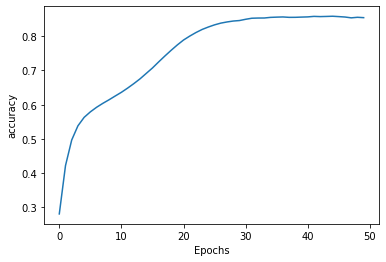

In [123]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

# Now Generating Text

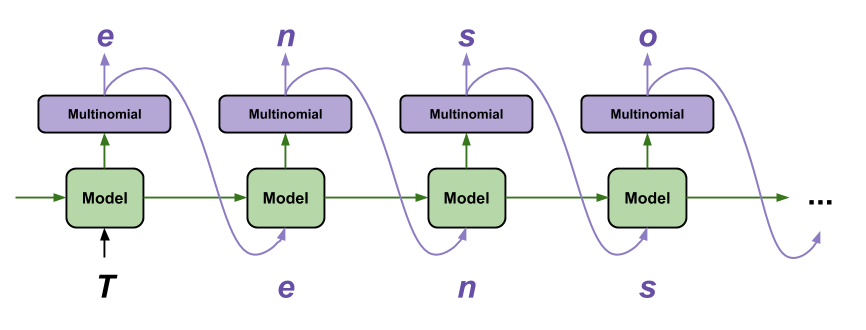

In [124]:
#The following makes a single step prediction: (There is a option to make a batch prediction as well)

class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):   #adjust the temperature parameter to generate more or less random predictions.
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [126]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
This shall incrence this idle hours.

LUCIO:
Richard, be advised.

COMINIUS:
You are at point to enter thee
From this world with many sorrow's plemation,
And so I cours but one what I must to them all;
Or what is in this world condition to become
A visitation with the ruin and duty,
Look down, and be in pains of heart
That weigh'd makes one hour that hath done
Than this of it. To marry her!
In all with sighs; and what you promised, he is,
We will grief when they say is the right Vincontious seas?
I call'd thee on our better disposition,
From with fornicatious princely rage! why, no, go, help it off.
I am but some of those that hapes milly one,
I will revenge his friends in the firm
Of fixhily wedding counted in this wrong,
Or as the day before ' mad adone'
Tut, that thy soul hours with such voices
In hope to go with us upon the day.
A tribunes and defence: we came from thee:
Sufficiency down his things.

ISABELLA:
Good morrow, Catesby, what was my son too?

BRUTUS:
Could you mad